In [1]:
#@title 📑   Data Building. Practice Project 1_0: Letter Detection </br> Header Styling
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def ch1(params):
    params=params.split('|'); header=params[0]
    fd={'font_size':'30','font_family':'Akronim','cmap':'Turbo'}
    if len(params)==2:  fd['font_size']=params[1]
    elif  len(params)==3: 
        fd['font_size']=params[1]; fd['font_family']=params[2]
    elif  len(params)==4:
        fd={'font_size':params[1],'font_family':params[2],'cmap':params[3]}
    url='https://fonts.googleapis.com/css?family='+fd['font_family']+'&effect=3d'
    html_str="""
    <script src='https://d3js.org/d3.v6.min.js'></script>
    <style>@import '"""+url+"""'; #ch1 {padding-left:20px;
    font-family:"""+fd['font_family']+"""; 
    font-size:"""+fd['font_size']+"""px;}</style>
    <h1 id='ch1' class='font-effect-3d'>"""+header+"""</h1>
    <script>var tc=setInterval(function(){
        var now=new Date().getTime(),doc=document.getElementById('ch1');
        doc.style.color=d3.interpolate"""+fd['cmap']+"""(now%(30000)/30000);},1)
    </script>"""
    display(HTML(html_str))

In [2]:
%ch1 Code Modules & Settings

In [3]:
import os,zipfile,h5py,cv2,urllib,requests
import numpy as np,tensorflow as tf,pylab as pl
file_path='https://olgabelitskaya.gitlab.io/data/letters/'
img_size=2048; img_size_out=32
file_pre,file_list,file_name='',[],''
tf_img,img,gray_img,edges=[],[],[],[]
lc,uc=0,0; edge_kernel=0
closed_edges,contours,contour_img=[],[],[]
names=[['lowercase','uppercase'],
       [s for s in u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'],
       ['single-colored paper','striped paper',
        'squared paper','graph paper']]

In [4]:
%ch1 Image Loading

In [5]:
def tf_get_img(file_name,file_path=file_path,img_size=img_size):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    img=tf.io.read_file(file_name)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-int(1)],tf.float32)
    new_shape=tf.cast(shape*img_size/max(shape),tf.int32)
    img=tf.image.resize(img,new_shape)
    return img[tf.newaxis,:]
def cv_get_img(file_name,lower_canny,upper_canny,
               file_path=file_path,img_size=img_size):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    img=cv2.imread(file_name)   
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    edges=cv2.Canny(gray_img,int(lower_canny),int(upper_canny))
    cv2.waitKey(int(0))
    return img/255.,gray_img,edges

In [6]:
def get_params(lower_upper,letter,background,
               lower_canny,upper_canny):
    global file_pre,file_list,file_name,tf_img,img,gray_img,edges,lc,uc    
    file_pre='%02d_'%names[0].index(lower_upper)
    file_pre+='%02d_'%names[1].index(letter)
    file_pre+='%02d_'%names[2].index(background)
    print('file prefix: '+file_pre)
    file_list=np.array([file_pre+'%02d'%(i+1)+'.jpg' for i in range(4)])
    file_name=file_list[0]
    lc,uc=lower_canny,upper_canny
    print('[lower_canny,upper_canny] = %s'%str([lc,uc]))
    tf_img=tf_get_img(file_name)
    img,gray_img,edges=cv_get_img(file_name,lc,uc)
    pl.figure(figsize=(16,12)); i=1
    for el in [tf_img.numpy()[0],img,gray_img,edges]:
        pl.subplot(2,2,i)
        pl.imshow(el,cmap='bone'); i+=1
    pl.show()

file prefix: 00_00_00_
[lower_canny,upper_canny] = [20, 110]


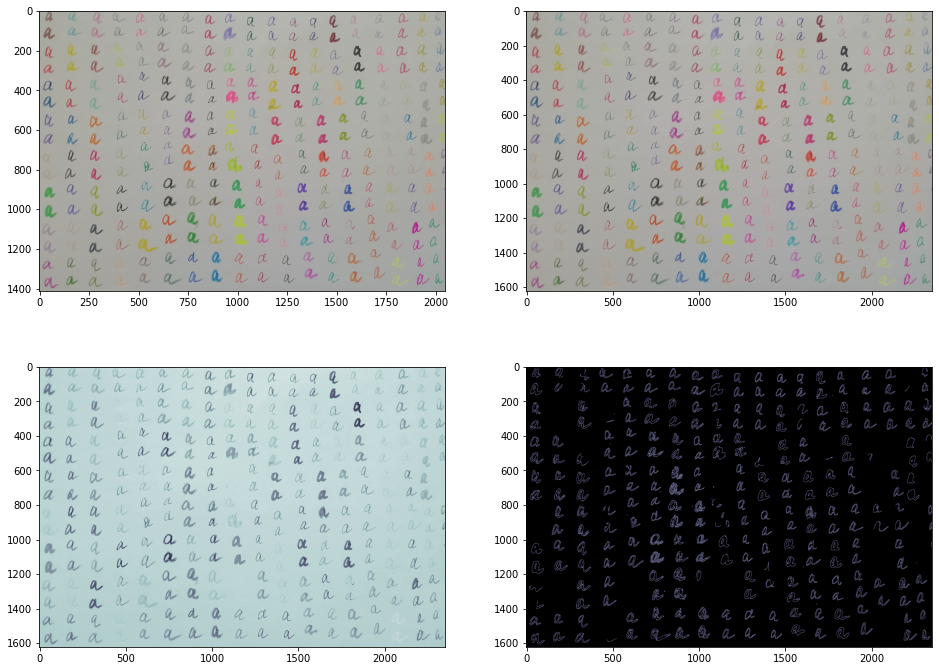

In [7]:
lower_upper='lowercase'; letter='а'
background='single-colored paper'
lower_canny,upper_canny=20,110
get_params(lower_upper,letter,background,lower_canny,upper_canny)

In [8]:
%ch1 Contour Detection

In [9]:
def get_closed_img(edges,edge_kernel):
    kernel=cv2.getStructuringElement(
        cv2.MORPH_RECT,(edge_kernel,edge_kernel))
    closed_edges=cv2.morphologyEx(edges,cv2.MORPH_CLOSE,kernel) 
    cv2.waitKey(0)
    return closed_edges
def get_contours(gray_img,closed_edges):
    (contours, _)=cv2.findContours(
        closed_edges.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours: 
        arc=cv2.arcLength(c,True) 
        approx_pdp=cv2.approxPolyDP(c,.02*arc,True) 
        contour_img=cv2.drawContours(
            gray_img,[approx_pdp],-1,(0,255,0),2)
    cv2.waitKey(0)
    return contours,np.array(contour_img)
def get_kernel(select_kernel):
    global edge_kernel,closed_edges,contours,contour_img
    edge_kernel=select_kernel
    closed_edges=get_closed_img(edges,edge_kernel)
    contours,contour_img=get_contours(gray_img,closed_edges)
    pl.figure(figsize=(16,6)); i=1
    for el in [closed_edges,contour_img]:
        pl.subplot(1,2,i)
        pl.imshow(el,cmap='bone'); i+=1
    pl.show()    

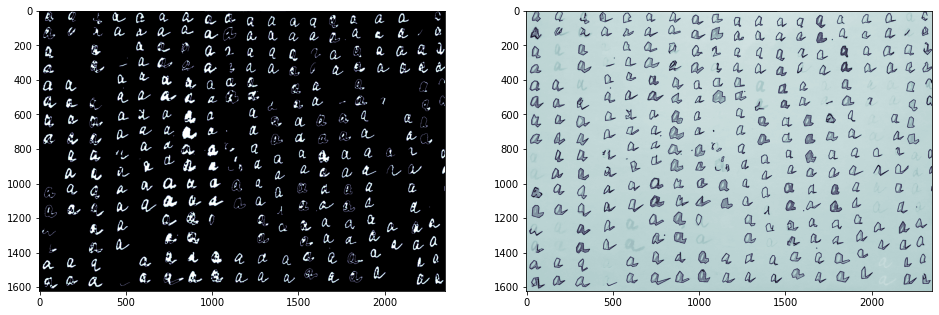

In [10]:
select_kernel=7; get_kernel(select_kernel)

In [11]:
%ch1 Data Building

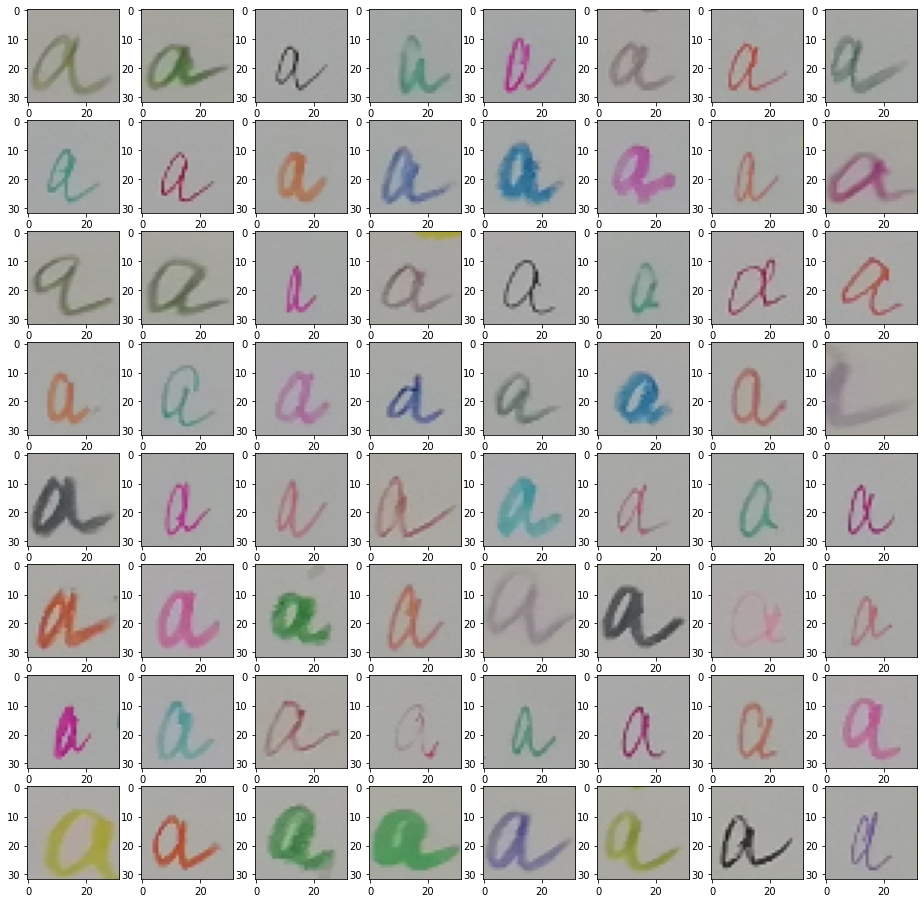

In [12]:
def get_imgs(contours,img_size_out=img_size_out):
    imgs=[]
    for c in contours: 
        x,y,w,h=cv2.boundingRect(c)
        m=np.random.randint(10,20)
        if (w>30 and w<250 and h>30 and h<250):
            y1=int(y*(1-.0015*m))
            y2=int((y+h)*(1+.0005*m))
            x1=int(x*(1-.001*m))
            x2=int((x+w)*(1+.001*m))
            new_img=img[y1:y2,x1:x2]
            if min(new_img.shape[0],new_img.shape[1])>30:
                new_img=cv2.resize(new_img,(img_size_out,img_size_out))
                imgs.append(new_img)
    return np.array(imgs)
imgs=get_imgs(contours); n_img=7
def get_images(image_number=64):
    global imgs
    if len(imgs)<16: image_number=8
    pl.figure(figsize=(16,16))
    for i in range(1,image_number+1):
        pl.subplot(image_number//8,8,i);
        pl.imshow(imgs[i],cmap='bone')
    pl.show();
get_images()

In [13]:
%ch1 Data ZIP Storing

In [14]:
file_list_out=[]; file_name_zip=file_pre[:-1]+'.zip'
def get_zip(imgs,start=0):
    global file_name_zip,file_pre,file_list_out
    current_list_out=[]
    for i in range(len(imgs)):
        idx=start+i
        file_name_img=file_pre+'%04d'%idx+'.png'
        cv2.imwrite(file_name_img,imgs[i]*255.)
        if (file_name_zip not in os.listdir()):
            with zipfile.ZipFile(file_name_zip,'w') as f:
                f.write(file_name_img); f.close()
        else:
            with zipfile.ZipFile(file_name_zip,'a') as f:
                f.write(file_name_img); f.close()
        os.remove(file_name_img)
        current_list_out+=[file_name_img]
    file_list_out+=current_list_out 
    return file_list_out
file_list_out=get_zip(imgs)

252


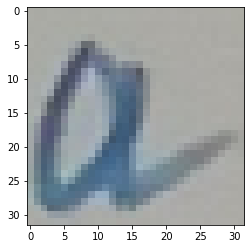

In [15]:
n=np.random.randint(len(file_list_out)) 
with zipfile.ZipFile(file_name_zip) as z:
    with open(file_list_out[n],'wb') as f:
        f.write(z.read(file_list_out[n]))
example_img=cv2.imread(file_list_out[n])
print(len(file_list_out)) 
pl.imshow(example_img/255.);

In [16]:
%ch1 Data H5 Storing

In [17]:
file_name_h5=file_pre[:-1]+'.h5'
lbls=[[int(file_pre[:2]),int(file_pre[3:5]),int(file_pre[6:8])]
      for i in range(len(imgs))]
imgs=np.array(imgs,dtype='float32')
lbls=np.array(lbls,dtype='int32')
print(imgs.shape,lbls.shape)
maxlen=max([max([len(n) for n in names[i]]) for i in range(len(names))])
nms=[np.array([np.string_(name.encode('utf-8')) for name in names[i]],
              dtype='S%d'%maxlen) for i in range(len(names))]
with h5py.File(file_name_h5,'w') as f:
    f.create_dataset('images',data=imgs,compression='gzip')
    f.create_dataset('labels',data=lbls,compression='gzip')
    for i in range(len(names)): 
        f.create_dataset('names%d'%(i+1),data=nms[i],
                         dtype='S%d'%maxlen,compression='gzip')
    f.close()

(252, 32, 32, 3) (252, 3)


file keys: images, labels, names1, names2, names3


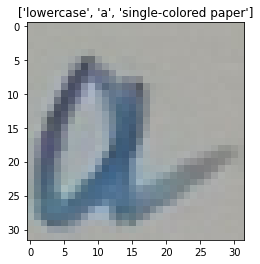

In [18]:
with h5py.File(file_name_h5,'r') as f:
    keys=list(f.keys())
    print('file keys: '+', '.join(keys))
    images=np.array(f[keys[0]]); labels=np.array(f[keys[1]])
    names=[[el.decode('utf-8') for el in f[keys[i]]]
           for i in range(2,len(keys))]
    f.close()
ti=[names[i][labels[n,i]] for i in range(3)]
pl.imshow(images[n]); pl.title(str(ti));

In [19]:
%ch1 ZIP Storing of All Images with the Same Labels

In [20]:
if (file_name_zip in os.listdir()): os.remove(file_name_zip)
start=0; file_list_out=[]
letter_names=(
    [['name %d'%i,[np.string_(name.encode('utf-8')) for name in names[i]]] 
     for i in range(len(names))])
np.savetxt('letter_names.txt',[str(letter_names)],fmt='%s')
print('letter labels: '+letter_names[1][1][0].decode('utf-8')+\
      '-'+letter_names[1][1][32].decode('utf-8'))
with zipfile.ZipFile(file_name_zip,'w') as f:
    f.write('letter_names.txt')      
def file_exist(file_name,file_path=file_path):
    r=requests.head(file_path+file_name)
    exist={'True':'exists','False':'does not exist'}
    print(file_path+file_name,exist[str(r.status_code==int(200))])
    return r.status_code==int(200)
for f in file_list:
    if file_exist(f):
        img,gray_img,edges=cv_get_img(f,lc,uc)
        closed_edges=get_closed_img(edges,edge_kernel)
        contours,contour_img=get_contours(gray_img,closed_edges)
        imgs=get_imgs(contours)
        file_list_out=get_zip(imgs=imgs,start=start)
        start=int(file_list_out[-1][-7:-4])+1
    else: break
file_list_out[-1]

letter labels: а-я
https://olgabelitskaya.gitlab.io/data/letters/00_00_00_01.jpg exists
https://olgabelitskaya.gitlab.io/data/letters/00_00_00_02.jpg exists
https://olgabelitskaya.gitlab.io/data/letters/00_00_00_03.jpg does not exist


'00_00_00_0491.png'

In [21]:
%ch1 H5 Storing of All Images with the Same Labels

In [ ]:
file_name_h5=file_pre[:-1]+'.h5'; imgs,lbls=[],[]
def file_exist(file_name,file_path=file_path):
    r=requests.head(file_path+file_name)
    exist={'True':'exists','False':'does not exist'}
    print(file_path+file_name,exist[str(r.status_code==int(200))])
    return r.status_code==int(200)
for f in file_list:
    if file_exist(f):
        img,gray_img,edges=cv_get_img(f,lc,uc)
        closed_edges=get_closed_img(edges,edge_kernel)
        contours,contour_img=get_contours(gray_img,closed_edges)
        imgs0=get_imgs(contours); imgs.append(imgs0)
        lbls.append(
            [[int(file_pre[:2]),int(file_pre[3:5]),int(file_pre[6:8])]
             for i in range(len(imgs0))])
imgs=np.array(np.vstack(imgs),dtype='float32')
lbls=np.array(np.vstack(lbls),dtype='int32')
print(imgs.shape,lbls.shape)
maxlen=max([max([len(n) for n in names[i]]) for i in range(len(names))])
nms=[np.array([np.string_(name.encode('utf-8')) for name in names[i]],
              dtype='S%d'%maxlen)
           for i in range(len(names))]
with h5py.File(file_name_h5,'w') as f:
    f.create_dataset('images',data=imgs,compression='gzip')
    f.create_dataset('labels',data=lbls,compression='gzip')
    for i in range(len(names)): 
        f.create_dataset('names%d'%(i+1),data=nms[i],
                         dtype='S%d'%maxlen,compression='gzip')
    f.close()